In [30]:
# Run this cell, do not need RenameOCR
# In future, revise Kanji OCR, 
import pandas as pd

df = pd.read_excel('pilot_data_ocr1.xlsx', engine='openpyxl')
commonkaha = ['は', 'か', 'へ', 'で', 'す', 'あ', 'お',
              'の', 'に', 'を', 'る', 'く', 'し', 'な', 'よ', 'ス', 'ル']
commonkanji = ['日', '事', '人', '一', '見', '本', '子', '出', '年', '大',
               '言', '学', '分', '中', '記', '会', '新', '月', '時', '行',
               '本', '立', '気', '報', '思', '上', '語', '自', '者', '生',
               '文', '明', '情', '国', '朝', '用', '書', '私', '手', '間', '小', '合']
kaha_sets = {char: set() for char in commonkaha}
kanji_sets = {char: set() for char in commonkanji}
for i in range(len(df)):
    group = df.iloc[i].group
    first = df.iloc[i].ocr
    filename = df.iloc[i].filename
    if first in commonkaha:
        kaha_sets[first].add(group +"/"+filename)
    # Check if the first character is in commonkanji
    elif first in commonkanji:
        kanji_sets[first].add(group+"/"+filename)

#は: {'B/B_3_47.jpg', 'D/D_4_5.jpg', 'B/B_5_17.jpg', 'Grant/25.jpg', 'C/C_4_15.jpg', 'B/B_3_1.jpg'}

In [31]:
directory = 'cluster'
if not os.path.exists(directory):
    os.makedirs(directory)
count_csv = 0
# Iterate through each key-value pair in the dictionary and create a CSV file
for key, images in kaha_sets.items():
    # Convert the set of images to a list and then to a DataFrame
    df = pd.DataFrame(list(images), columns=['Image_name'])
    
    # Define the path with the directory and file name
    file_path = os.path.join(directory, f'{key}.csv')
    
    # Save the DataFrame to a CSV file, naming the file using the key
    df.to_csv(file_path, index=False)
    count_csv += 1
    
for key, images in kanji_sets.items():
    # Convert the set of images to a list and then to a DataFrame
    df = pd.DataFrame(list(images), columns=['Image_name'])
    
    # Define the path with the directory and file name
    file_path = os.path.join(directory, f'{key}.csv')
    
    # Save the DataFrame to a CSV file, naming the file using the key
    df.to_csv(file_path, index=False)
    count_csv += 1
print(f"{count_csv} CSV files have been created.")

58 CSV files have been created.


In [32]:
import os

def clean_csv_files(directory):
    # Define the markers to look for
    markers = ["<<<<<", "=====", ">>>>>"]
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        # Check if the file is a CSV
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            
            # Read the file
            with open(file_path, 'r', encoding='utf-8') as file:
                lines = file.readlines()

            # Separate the header (first line)
            header = lines[0]
            data_lines = lines[1:]

            # Remove lines containing markers and eliminate duplicates using a set
            cleaned_lines = set(line for line in data_lines if not any(marker in line for marker in markers))

            # Write the header and cleaned, unique data lines back to the same file
            with open(file_path, 'w', encoding='utf-8') as file:
                file.write(header)  # Write the header first
                file.writelines(sorted(cleaned_lines))  # Sorting optional, to maintain consistent order

# Example usage
directory_path = 'cluster'  # Replace with the path to your directory containing CSV files
clean_csv_files(directory_path)



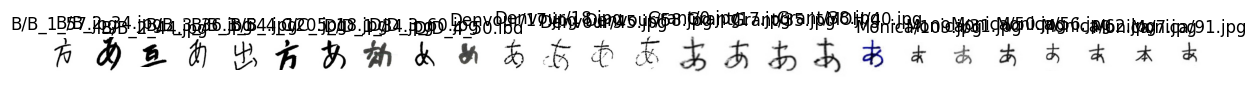

In [2]:
# C/C_1_1.jpg
# D/D_5_42.jpg
# D/D_4_8.jpg
# D/D_3_21.jpg
# D/D_5_5.jpg
# B/B_5_3.jpg
# B/B_3_40.jpg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
image_folder_path = '../../pilot data/data/'
source_path = 'cluster/あ.csv'
df = pd.read_csv(source_path)
plt.figure(figsize=(15, 5))
for i in range(len(df)):
    image_path = os.path.join(image_folder_path, df.iloc[i]['Image_name'])
    image = plt.imread(image_path)
    
    # Create a subplot for each image
    ax = plt.subplot(1, len(df), i + 1)  # (1, number of images, index of current image)
    ax.imshow(image)
    ax.set_title(df.iloc[i]['Image_name'])
    ax.axis('off')  # Turn off axis labels and ticks

plt.show()

In [30]:
# Feature extraction part
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import cv2
import os
def label_image(img,cornerlist):
    """
    Label the correspond point in the image 
    Parameters:
    - img:  np.ndarray image read by plt
    - cornerlist : A list which store coordinate to highlight. 
    
    Returns: 
    - The labeled image. 
    """
    # iterate all the point in the coordinate list. 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for (x,y) in cornerlist:
        #x is row, y is column
        cv2.circle(img,(y,x),1, (0, 255, 0), -1)
    # return the image. 
    return img
def non_max_suppression(cornresult: np.ndarray, threshold: float = 0.01, K_size: int = 3) -> List[Tuple[int, int]]:
    """
    Utilize the result of Harris Corner Detection to fitrate those 
    local maxima (corners) and returned.

    Parameters:
    - cornresult: 2D array obtained from Harris_Corner()
    - threshold: Hyperparameter to determine a local maximum is considered a corner.
    - K_size: Size of the kernel used for non-maximum suppression.

    Returns:
    - List of tuples (row, column) indices of detected corners.
    """
    m, n = cornresult.shape
    supresult = []
    # Adding boundary to origin image so that can apply kernel on them
    k_half = K_size // 2
    padded_result = np.pad(cornresult, pad_width=k_half, mode='constant', constant_values=0)
    threshold = threshold * np.max(cornresult)
    # Iterate over the original image dimensions
    for r in range(m):
        for c in range(n):
            center_value = cornresult[r, c]
            if center_value == 0:
                continue
            # Extract 3*3 kernel
            local_patch = padded_result[r + k_half - k_half : r + k_half + k_half + 1,
                                        c + k_half - k_half : c + k_half + k_half + 1]
            # Ignore the corners of the padded_result, which correspond to the padding area
            if (r - k_half == 0 or r + k_half == m + k_half - 1 
                or c - k_half == 0 or c + k_half == n + k_half - 1):
                continue
            if center_value == np.max(local_patch) and center_value > threshold:
                supresult.append((r, c))
    
    return supresult

def pad_images_to_size(img, target_size=(80, 80)):
    
    if img is not None:
        h, w = img.shape[:2]
        if h > target_size[1] or w > target_size[0]: # adjust size in case image too big or too small
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        elif h < target_size[1] or w < target_size[0]:
            top = (target_size[1] - h) // 2
            bottom = target_size[1] - h - top
            left = (target_size[0] - w) // 2
            right = target_size[0] - w - left
            img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    return img
def load_local_image(file_path):
    """ load local images """
    if os.path.exists(file_path):
        image = cv2.imread(file_path)
        return image
    else:
        print(f"{file_path} doesnt exist")
        return None

import cv2
import matplotlib.pyplot as plt

def preprocess_image(image, margin=10, fixed_size=(200, 200)):
    if image is None:
        print("Nothing to preprocess")
        return None

    # convert it into grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # threshold
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    return binary

def extract_features(binary_image):
    features = {
        'white_pixels_ratio': np.sum(binary_image > 128) / binary_image.size
    }
    return features


#extract features with images set
def process_image_set(image_set, dir_path):
    """ deal with a set of image and feature extraction """
    features_list = []
    for file_name in image_set:
        file_path = os.path.join(dir_path, file_name)
        image = cv2.imread(file_path)
        if image is not None:
            preprocessed_image = preprocess_image(image)
            if preprocessed_image is not None:
                features = extract_features(preprocessed_image)
                if features is not None:
                    features_list.append(features)
            else:
                print(f"preprocessing {file_name} failed")
        else:
            print(f"loading {file_name} failed")
    return features_list
    
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import cv2
import os
# source_path = 'cluster/あ.csv'
df = pd.read_csv(source_path)
sum_m = 0
sum_n = 0
for i in range(len(df)):
    image_path = os.path.join(image_folder_path, df.iloc[i]['Image_name'])
    Img = cv2.imread(image_path)
    m,n = Img.shape[0],Img.shape[1]
    sum_m += m
    sum_n += n
sum_m = sum_m // len(df)
sum_n = sum_n // len(df)

feature_dots_len =[]
feature_dots = []
plt.figure(figsize=(15, 5))
for i in range(len(df)):
    image_path = os.path.join(image_folder_path, df.iloc[i]['Image_name'])
    Img = cv2.imread(image_path)
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
    Img = pad_images_to_size(Img,(round(sum_m),round(0.7*sum_n)))
    if Img.ndim == 3:
        gray_Img = cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)
    else:
        gray_Img = Img  # If Img is already in grayscale

    #in-build function
    in_build_harris  = cv2.cornerHarris(gray_Img, 2, 3, 0.04)
    in_build_corner = non_max_suppression(in_build_harris)
    feature_dots.append(in_build_corner)
    feature_dots_len.append(len(in_build_corner))
    # convert image back to rgb form to display
    rgb_Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)

    img_with_corners = label_image(rgb_Img,in_build_corner)
#     plt.figure(figsize=(15, 5))

#     ax = plt.subplot(1,len(df),  i + 1)  # (number of rows, number of cols, index)
#     ax.imshow(img_with_corners)
#     ax.set_title('Harris Corner: ' + df.iloc[i]['Image_name'])
#     ax.axis('off')  # Hide axes

# plt.tight_layout()  # Adjust layout to fit all elements
# plt.show()
#extract features from image
feature_list = []
image_folder_path = '../../pilot data/data/'

# source_path = 'cluster/あ.csv'
df = pd.read_csv(source_path)
for i in range(len(df)):
    image_path = os.path.join(image_folder_path, df.iloc[i]['Image_name'])
    image = load_local_image(image_path)
    if image is not None:
        preprocessed_image = preprocess_image(image)
        if preprocessed_image is not None:
            features = extract_features(preprocessed_image)
            if features is not None:
                feature_list.append((df.iloc[i]['Image_name'],features))
def compute_corner_density(corners, image_width, image_height):
    num_corners = len(corners)
    area = image_width * image_height
    density = num_corners / area
    return density

def compute_corner_stats(corners):
    x_coords = [coord[0] for coord in corners]
    y_coords = [coord[1] for coord in corners]
    
    stats = {
        'mean_x': np.mean(x_coords),
        'mean_y': np.mean(y_coords),
        'var_x': np.var(x_coords),
        'var_y': np.var(y_coords)
    }
    return stats

def compute_bounding_box_size(corners):
    x_coords = [coord[0] for coord in corners]
    y_coords = [coord[1] for coord in corners]
    
    min_x = min(x_coords)
    max_x = max(x_coords)
    min_y = min(y_coords)
    max_y = max(y_coords)
    
    width = max_x - min_x
    height = max_y - min_y
    return width, height

for index, (img,feature) in enumerate(feature_list):
    corners = feature_dots[index]
    dots_len = feature_dots_len[index]
    density = compute_corner_density(corners, sum_m,round(sum_n*0.7))
    stats = compute_corner_stats(corners)
    s_width,s_height = compute_bounding_box_size(corners)
    feature['corner_num'] = dots_len
    feature['corner_density'] = density
    for k,v in stats.items():
        feature[k] = v
    feature['smallest_width'] = s_width
    feature['smallest_height'] = s_height


print(str(feature_list[0][:]))


('B/B_1_57.jpg', {'white_pixels_ratio': 0.09206766046188306, 'corner_num': 19, 'corner_density': 0.0017025089605734768, 'mean_x': 34.31578947368421, 'mean_y': 59.78947368421053, 'var_x': 489.1634349030471, 'var_y': 203.00831024930747, 'smallest_width': 82, 'smallest_height': 52})


<Figure size 1500x500 with 0 Axes>

In [31]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import os
from sklearn.decomposition import PCA
data = []
for file_name, features in feature_list:
    entry = [
        features['white_pixels_ratio'],
        features['corner_num'],
        features['corner_density'],
        features['mean_x'],
        features['mean_y'],
        features['var_x'],
        features['var_y'],
        features['smallest_width'],
        features['smallest_height']
    ]
    data.append(entry)

data = np.array(data)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)



In [32]:
from sklearn.decomposition import PCA # DBSCAN
from sklearn.cluster import DBSCAN

pca = PCA(n_components= 3) #higher, stricter
data_reduced = pca.fit_transform(data_scaled)

dbscan = DBSCAN(eps = 2, min_samples=2) #eps lower, stricter
dbscan.fit(data_reduced)

clusters = dbscan.labels_

print("Cluster assignments after PCA:", clusters)

Cluster assignments after PCA: [0 0 0 0 0 0 0 0 1 0 2 2 2 2 3 3 3 3 1 1 1 1 1 1 1 1]


Cluster 0: ['B/B_1_57.jpg', 'B/B_2_34.jpg', 'B/B_2_44.jpg', 'B/B_3_36.jpg', 'B/B_3_54.jpg', 'B/B_4_120.jpg', 'C/C_5_18.jpg', 'D/D_1_34.jpg', 'D/D_4_50.jpg']


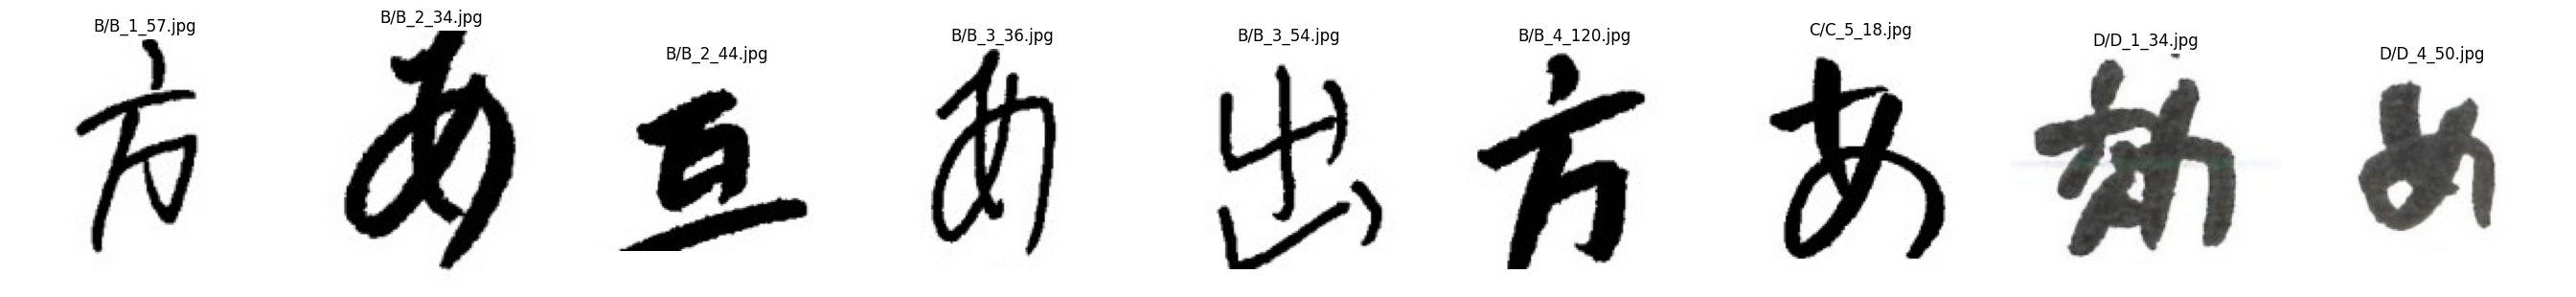

Cluster 1: ['D/D_3_60.jpg', 'MOH/40.jpg', 'Monica/109.jpg', 'Monica/31.jpg', 'Monica/50.jpg', 'Monica/56.jpg', 'Monica/62.jpg', 'Monica/7.jpg', 'Monica/91.jpg']


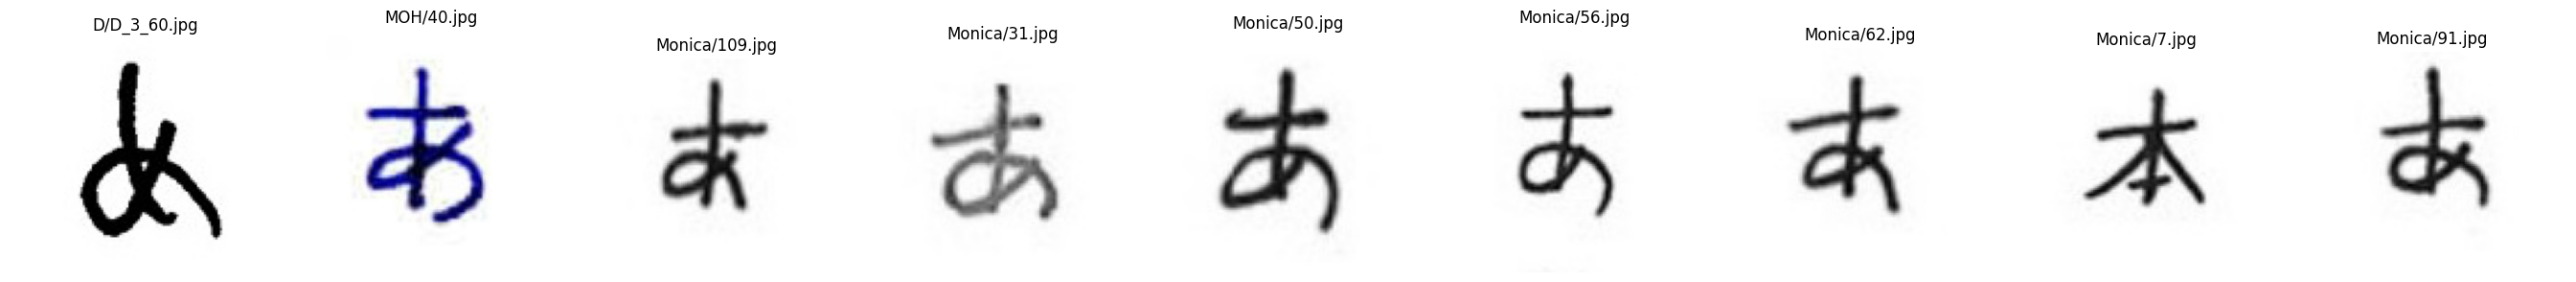

Cluster 2: ['Denvour/17.jpg', 'Denvour/18.jpg', 'Denvour/45.jpg', 'Denvour/58.jpg']


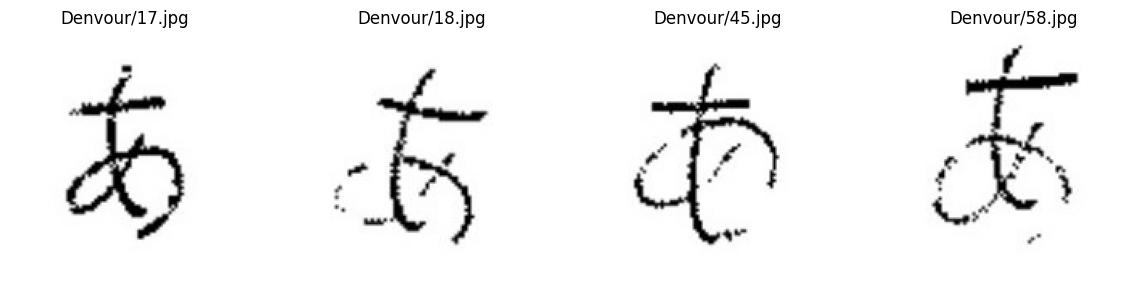

Cluster 3: ['Grant/0.jpg', 'Grant/17.jpg', 'Grant/35.jpg', 'Grant/38.jpg']


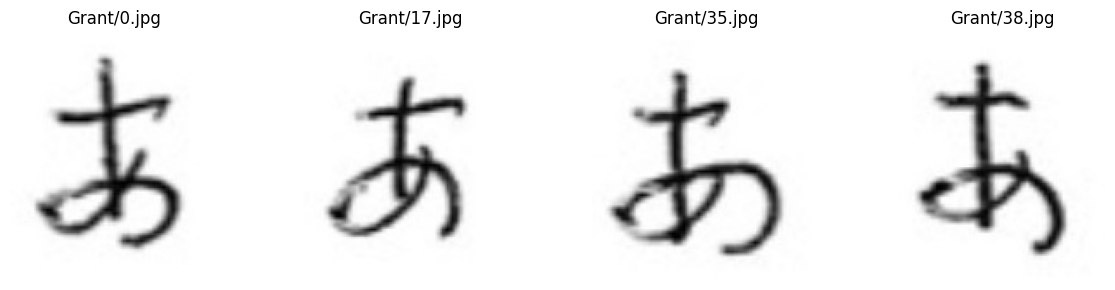

After classifying with DBSCAN, the following images are likely to have the same author:

'B/B_1_57.jpg', 'B/B_2_34.jpg', 'B/B_2_44.jpg', 'B/B_3_36.jpg', 'B/B_3_54.jpg', 'B/B_4_120.jpg', 'C/C_5_18.jpg', 'D/D_1_34.jpg', and 'D/D_4_50.jpg' have the same author.

'D/D_3_60.jpg', 'MOH/40.jpg', 'Monica/109.jpg', 'Monica/31.jpg', 'Monica/50.jpg', 'Monica/56.jpg', 'Monica/62.jpg', 'Monica/7.jpg', and 'Monica/91.jpg' have the same author.

'Denvour/17.jpg', 'Denvour/18.jpg', 'Denvour/45.jpg', and 'Denvour/58.jpg' have the same author.

'Grant/0.jpg', 'Grant/17.jpg', 'Grant/35.jpg', and 'Grant/38.jpg' have the same author.


In [33]:
from collections import defaultdict

cluster_dict = defaultdict(list)

# Populate the cluster dictionary based on DBSCAN labels
for index, cluster_label in enumerate(dbscan.labels_):
    image_name = feature_list[index][0]
    cluster_dict[cluster_label].append(image_name)

# Display the clustering results
cluster_images = []
for cluster, images in cluster_dict.items():
    if cluster != -1:  # -1 represents noise in DBSCAN, you might want to ignore it
        print(f"Cluster {cluster}: {images}")
        imageset = []
        plt.figure(figsize=(3 * len(images), 3))
        for index, img_name in enumerate(images):
            
            image_path = os.path.join(image_folder_path, img_name)
            image = plt.imread(image_path)
            ax = plt.subplot(1, len(images), index + 1)
            ax.imshow(image)
            ax.set_title(img_name)
            ax.axis('off')
            imageset.append(img_name)
        plt.tight_layout()
        plt.show()
        cluster_images.append(imageset)

# Summarize the clustering results
print(f"After classifying with DBSCAN, the following images are likely to have the same author:")
if len(cluster_images) >= 1:
    for images in cluster_images:
        if len(images) > 1:
            images_formatted = "', '".join(images[:-1])
            print()
            summary_statement = f"'{images_formatted}', and '{images[-1]}' have the same author."
            print(summary_statement)